In [1]:
# to suppress futurewarnings caused by pandas and other libraries not updating their numpy interface codes
# apparently has to come before these import, so leave this on top
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as stats
import pandas as pd

%matplotlib inline

# Chapter 5
* **multivariate regression**: using more than one predictor variable to model an outcome. useful b/c
  * control for confounds. **confound**: variable that might be correlated w/ variable of interest, e.g. nr of waffle houses and divorce rate. can hide important variables or can create false importance. **simpson's paradox**: reverse direction between predictor and outcome due to confound.
  * multiple causation. something might be caused by more than one thing
  * interactions. car needs fuel and spark to start, only one does not have any effect.
* this chapter: confounds and multiple causation
* also danger: multicollinerarity
* **rethinking: causal inference:** extremely important, but no unified approach to determine causal effect, neither in sciences nor in statistic. furthermore, 'cause' loses clear meaning in complex systems in which everything seems to cause everything (and be caused by it). consensus: inference of causality always rests upon unverifiable assumptions. so no matter the analysis, there will always be possible criticism about whether there really is causality. however: even despite that useful work can be done

## 5.1. Spurious association
* impact of median marriage age of marriage on divorce rate

In [2]:
# Code 5.1
d = pd.read_csv('./data/WaffleDivorce.csv', sep=';')

In [3]:
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [4]:
d['MedianAgeMarriage_s'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean()) / d.MedianAgeMarriage.std()

with pm.Model() as m5_1:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    bA = pm.Normal('bA', mu=0, sd=1)
    
    a = pm.Normal('a', mu=10, sd=10)
    
    mu = pm.Deterministic('mu', a + bA * d.MedianAgeMarriage_s)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    
    trace_m5_1 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1242.12draws/s]


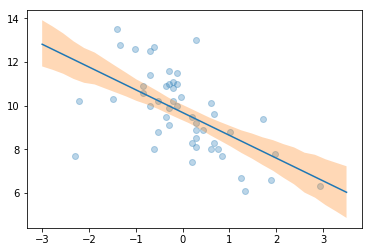

In [5]:
# Code 5.2
MAM_seq = np.linspace(-3, 3.5, 30)
mu = np.reshape(trace_m5_1['a'], (-1, 1)) + np.reshape(trace_m5_1['bA'], (-1, 1)) * np.reshape(MAM_seq, (1, -1))
mu_PI = pm.hpd(mu, alpha=.11)
mu_mean = mu.mean(axis=0)

plt.scatter(x=d.MedianAgeMarriage_s, y=d.Divorce, alpha=.3);
plt.plot(MAM_seq, mu_mean);
plt.fill_between(x=MAM_seq, y1=mu_PI[:, 0], y2=mu_PI[:, 1], alpha=.3);

In [6]:
varnames = ['bA', 'a', 'sigma']

In [7]:
pm.summary(trace_m5_1, varnames=varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
bA,-1.044985,0.206649,0.003709,-1.488578,-0.681471,2820.340666,1.000660
a,9.683017,0.220562,0.004212,9.251629,10.126318,2725.126316,0.999605
sigma,1.511455,0.157998,0.003352,1.232616,1.834091,2214.054157,0.999598


In [8]:
# Code 5.3
d['Marriage_s'] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()

with pm.Model() as m5_2:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    bR = pm.Normal('bR', mu=0, sd=1)
    
    a = pm.Normal('a', mu=10, sd=10)
    
    mu = pm.Deterministic('mu', a + bR * d.Marriage_s)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    
    trace_m5_2 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1373.73draws/s]


In [9]:
pm.summary(trace_m5_2, varnames=['sigma', 'bR', 'a'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma,1.746797,0.183641,0.004345,1.397746,2.092496,2187.171427,0.999501
bR,0.636793,0.237130,0.004720,0.173189,1.097961,2380.261474,1.000617
a,9.688432,0.242662,0.004165,9.167984,10.130862,2738.934302,0.999500


* median age of marriage has stronger association with divorce rate than the one that marriage rate has
* however, does not answer which one is better predictor. they could have independent information, or be redundant or could eliminate each other
* want to build multivariate model to determine partial value added by each predictor. in particular, question is **what is predictive value of variable once i know value of all variables?**
* **rethinking: "control" is outside of control** this question often talked about as 'statistical control'. estimating effect of one variable while controlling for effect of another. however: sloppy language. implies causality ('effect') and dissasociation of predictors ('control'), neither of which is a fact in the model, even though it might be made by analyst. power of statistical methods does not extend to this, must be careful not to make this wrong impression, otherwise interpretation of results will also be based on wrong understanding

### 5.1.1. multivariate notation
* straightforward extension of univariate models, just add multiple parameters into formula for mean and add priors for their parameters for all of them
* what does $\mu_i = \alpha + \beta_R R_i + \beta_A A_i$ mean? expected outcome for any state is sum of three independent terms. can be read as "divorce rate can function of marriage rate ($R_i$) OR median marriage age ($A_i$)". "OR" implies that both factors are independent
* **overthinking: design matrix** **design matrix** = matrix of features with additional column of '1's in the beginning. used in equation $m = Xb$, where $m$ = predicted means (one for each row of data), $X$ = design matrix w/ one row per row of data, one col per predictor and extra '1' col and $b$ = col vector of parameters

### 5.1.2. fitting the model
* exactly as expected

In [10]:
# Code 5.4
with pm.Model() as m5_3:
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    a = pm.Normal('a', mu=10, sd=10)
    mu = pm.Deterministic('mu', a + bR * d.Marriage_s + bA * d.MedianAgeMarriage_s)
    
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    
    trace_m5_3 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a, bA, bR]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1000.83draws/s]


In [11]:
pm.summary(trace_m5_3, varnames=['bR', 'bA', 'a', 'sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
bR,-0.110882,0.285856,0.007217,-0.649333,0.443885,1394.373228,0.999894
bA,-1.116037,0.288756,0.007719,-1.644493,-0.505833,1411.361861,1.000785
a,9.694786,0.220299,0.005952,9.284025,10.134232,1552.877792,1.000620
sigma,1.525009,0.164438,0.003869,1.222122,1.846165,1618.274234,0.999964


In [12]:
params = ['sigma', 'bA', 'bR', 'a']

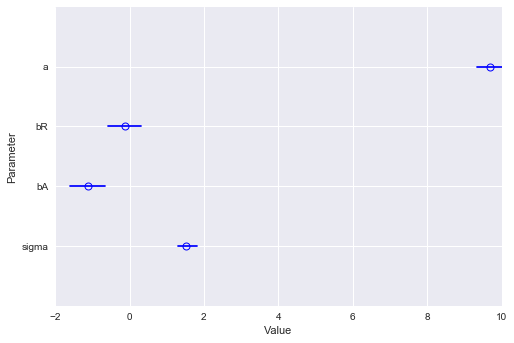

In [25]:
# Code 5.5
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots()
# ax.plot([1, 2, 3], [1, 2, 3])
ax.set(xlabel='Value', ylabel='Parameter')
ax.set_xlim(-2, 10)
ax.set_ylim(0, 5)
ax.set_yticks([1, 2, 3, 4])
ax.set_yticklabels(params)
for ix, pname in enumerate(params):
    # 'mwe' = marker edge weight
    # necessary to draw empty circles, defaults to 0, meaning circles will be invisible if not filled
    ax.plot(trace_m5_3[pname].mean(), ix+1, 'ob', fillstyle='none', mew=1)
    hpd_boundaries = pm.hpd(trace_m5_3[pname], alpha=.11)
    ax.plot(hpd_boundaries, [ix+1, ix+1], '-b')

* interpretation: "once we know median age of marriage, learning about marriage rate does not give us much additional information"
* **why is this the interpretation? are these factors not independent? see if this is answered in remainder of section, discuss**

### 5.1.3. plotting multivariate posteriors
* tons of books and other literature on specialized plots. but: none suitable to all jobs, typically don't generalize beyond linear regression.
* instead: understand approaches to ask model whatever interesting questions we come up with
* plot categories:
  * predictor residual plots
  * counterfactual plots. implied predictions for imaginary experiments
  * posterior prediction plots. model-based predictions against raw data or other types of prediction error
  
#### 5.1.3.1. Predictor residual plots
* idea: predict values of one predictor using all other predictors. calculate residuals of that prediction, i.e. how much of target predictor is not determined by combination of other predictors? plot these. 
* also calculate and plot dependent variable of overall problem (here: divorce rate) against these residuals. can even fit linear model between residuals and dependent variable. 
* interpretation: what's the association between residuals and dependent variable? positive residuals: predictor is higher than expected given other predictors. negative residuals: predictor is lower than expected given other residuals. is there a connection between this quantity and the dependent variable? e.g. is there a relation between predictor 'median age of marriage' being unexpectedly high/low and dependent variable 'divorce rate'?
* **still shaky on exact interpretation, discuss this**
* let's go through the code + examples, maybe can help to make things clearer

In [26]:
# Code 5.6
with pm.Model() as m5_4:
    
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    b = pm.Normal('b', mu=0, sd=1)
    a = pm.Normal('a', mu=0, sd=10)
    mu = pm.Deterministic('mu', a + b * d.MedianAgeMarriage_s)
    Marriage_s = pm.Normal('Marriage_s', mu=mu, sd=sigma, observed=d.Marriage_s)
    
    trace_m5_4 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1389.15draws/s]


In [31]:
# Code 5.7
trace_m5_4_pd = pm.trace_to_dataframe(trace_m5_4)
trace_m5_4_pd.head()

,b,a,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,-0.553924,-0.078014,0.630734,0.257824,0.302365,0.035120,0.703233,-0.410289,0.079661,-0.766616,...,0.124202,0.302365,0.302365,1.148642,-0.454830,-0.232126,-0.009421,0.391447,-0.187585,0.747774
1,-0.853210,0.097405,0.845001,0.614697,0.683304,0.271665,1.300761,-0.414399,0.340272,-0.963250,...,0.408878,0.683304,0.683304,1.986825,-0.483005,-0.139973,0.203059,0.820516,-0.071367,1.369367
2,-0.671320,0.174063,0.709821,0.581078,0.635058,0.311174,1.120884,-0.228632,0.365155,-0.660478,...,0.419136,0.635058,0.635058,1.660691,-0.282613,-0.012710,0.257194,0.743019,0.041271,1.174865
3,-0.751762,-0.202268,0.756857,0.253517,0.313966,-0.048728,0.858007,-0.653218,0.011721,-1.136810,...,0.072170,0.313966,0.313966,1.462497,-0.713667,-0.411422,-0.109177,0.434864,-0.350973,0.918456
4,-0.751762,-0.202268,0.756857,0.253517,0.313966,-0.048728,0.858007,-0.653218,0.011721,-1.136810,...,0.072170,0.313966,0.313966,1.462497,-0.713667,-0.411422,-0.109177,0.434864,-0.350973,0.918456


In [43]:
# each state corresponds to one of the 'mu_x' columns in the trace dataframe. for each sample of (a, b) a value of mu for
# each state (0 through 49) was calculated
# thus: MAP mu for state 0 = mean of mu_0 column, I think? **verify this**
mu = trace_m5_4_pd.filter(axis=1, like='mu__').mean()

In [48]:
# need '.values' to use ndarrays so that meaningless indices are ignored
m_resid = d.Marriage_s.values - mu.values

[Text(0,0.5,'Marriage_s'), Text(0.5,0,'MedianAgeMarriage_s')]

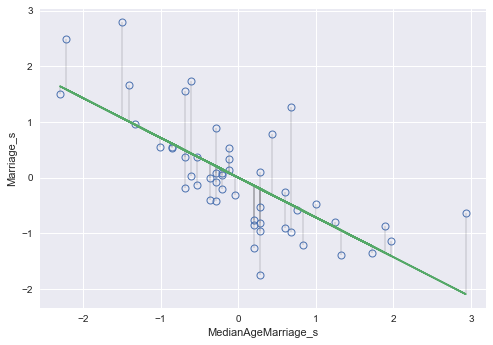

In [69]:
# Code 5.8
fig, ax = plt.subplots()
ax.plot('MedianAgeMarriage_s', 'Marriage_s', 'o', fillstyle='none', mew=1, data=d);
ax.plot(d.MedianAgeMarriage_s, mu)
ax.vlines(x=d.MedianAgeMarriage_s, ymin=mu, ymax=d.Marriage_s, alpha=0.1)
ax.set(xlabel='MedianAgeMarriage_s', ylabel='Marriage_s')

* grey lines = residuals
* side note: **this matches book plot, thus using mu_X samples to get map for datum X seems valid approach. neato**
* "notice that residuals are variation in marriage rate that is left over, after taking out the purely linear relationship between the two variables." **what does this mean exactly?**
* book includes more plots which plot residuals vs divorce rates. **how do i interpret those?**
  * book says: "you can think of this plot as displaying the linear relationship between divorce and marriage rates having statistically 'controlled' for median age of marriage" **still unclear what 'controlled for' _really, really_ means**
  * plots show that after 'controlling' for m_age, m_rate does not give a lot of extra info on d_rate. however, m_age *does* give a lot of extra info on d_rate after 'controlling' for d_age. thus: m_age higher predictive power, extra information not contained in m_rate?
  * book finds the following: assume that in multivariate model (m_rate, m_age) -> d_rate we find cofficients 0.1 for m_rate and 0.8 for m_age. Then if we fit a lin model like (m_rate_residuals_after_controlling_for_m_age) -> d_rate we'll find coefficient 0.1, and mutatis mutandis we'll find 0.8 for m_age_residuals_after_controlling_for_m_rate
  * learning the book takes from this: **coefficent in regression model is association between predictor and dependent variable when already knowing about all other predictors**
    * lin models do this assuming specific additivity between predictors. other models can assume other relationships between predictors. basic logic of statistical control stays the same, but residual plots do not work in the same way
    
#### 5.1.3.2. Counterfactual plots
* plot model predictions. 'counterfactual' b/c can also do this for predictor values that have not been observed or are straight up impossible
* simplest use: see how predictions behave when changing one predictor and keeping all others fixed
* helps understanding implications of model
* first example:

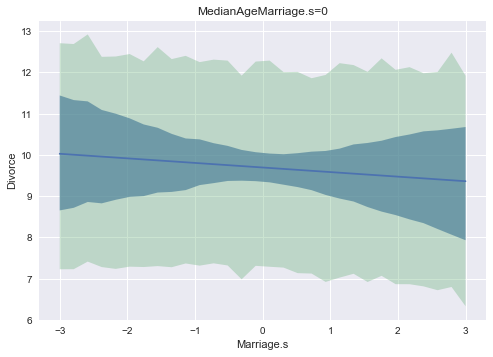

In [154]:
# Code 5.9

# prepare new counterfactual data

# note: isn't MedianAgeMarriage_s.mean() guaranteed to be 0 by definition of a standardized variable?
A_avg = d.MedianAgeMarriage_s.mean()
R_seq = np.linspace(start=-3, stop=3, num=30)
pred_data = pd.DataFrame(
    data={
        'Marriage_s': R_seq, 
        'MedianAgeMarriage_s': A_avg
    }
)

# compute counterfactual mean divorce (mu)

# mu dimensions: n_mcmc_samples x n_data_points
mu = trace_m5_3['a'].reshape(-1, 1) + trace_m5_3['bR'].reshape(-1, 1) @ pred_data.Marriage_s.values.reshape(1, -1) + trace_m5_3['bA'].reshape(-1, 1) @ pred_data.MedianAgeMarriage_s.values.reshape(1, -1)
mu_mean = mu.mean(axis=0)
mu_PI = pm.hpd(mu, alpha=0.11)

# R_sim dimensions same as mu dimensions. One col per mcmc sample, one row per input datum
R_sim = np.random.normal(loc=mu, scale=trace_m5_3['sigma'].reshape(-1, 1))
R_PI = pm.hpd(R_sim, alpha=0.11)

fig, ax = plt.subplots()
ax.set(xlabel='Marriage.s', ylabel='Divorce', title='MedianAgeMarriage.s=0');
ax.plot(R_seq, mu_mean);
# ax.plot(d.Marriage_s, d.Divorce, 'o', alpha=0.9, fillstyle='none', mew=1);
ax.fill_between(R_seq, y1=mu_PI[:, 0], y2=mu_PI[:, 1], alpha=0.7);
ax.fill_between(R_seq, y1=R_PI[:, 0], y2=R_PI[:, 1], alpha=0.3);

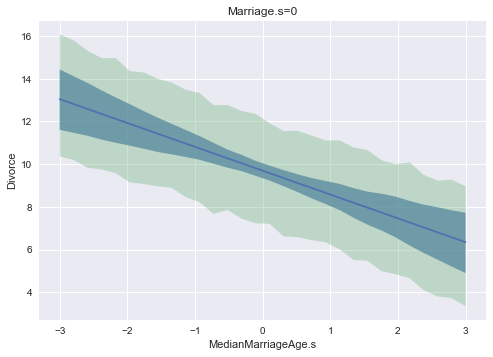

In [157]:
# Code 5.10

# prepare new counterfactual data

# note: isn't MedianAgeMarriage_s.mean() guaranteed to be 0 by definition of a standardized variable?
R_avg = d.Marriage_s.mean()
A_seq = np.linspace(start=-3, stop=3, num=30)
pred_data2 = pd.DataFrame(
    data={
        'Marriage_s': R_avg, 
        'MedianAgeMarriage_s': A_seq
    }
)

# compute counterfactual mean divorce (mu)

# mu dimensions: n_mcmc_samples x n_data_points
mu = trace_m5_3['a'].reshape(-1, 1) + trace_m5_3['bR'].reshape(-1, 1) @ pred_data2.Marriage_s.values.reshape(1, -1) + trace_m5_3['bA'].reshape(-1, 1) @ pred_data2.MedianAgeMarriage_s.values.reshape(1, -1)
mu_mean = mu.mean(axis=0)
mu_PI = pm.hpd(mu, alpha=0.11)

# R_sim dimensions same as mu dimensions. One col per mcmc sample, one row per input datum
R_sim = np.random.normal(loc=mu, scale=trace_m5_3['sigma'].reshape(-1, 1))
R_PI = pm.hpd(R_sim, alpha=0.11)

fig, ax = plt.subplots()
ax.set(xlabel='MedianMarriageAge.s', ylabel='Divorce', title='Marriage.s=0');
ax.plot(A_seq, mu_mean);
# ax.plot(d.Marriage_s, d.Divorce, 'o', alpha=0.9, fillstyle='none', mew=1);
ax.fill_between(A_seq, y1=mu_PI[:, 0], y2=mu_PI[:, 1], alpha=0.7);
ax.fill_between(A_seq, y1=R_PI[:, 0], y2=R_PI[:, 1], alpha=0.3);

* note: above 2 plots have different scales on y-axis. makes them harder to compare
* **don't display data b/c they're counterfactual**
* display data on percentile interval scale, not residual scale
* thus: direct depiction of how prediction varies w/ change in one predictor
* **watch out: these isolated effects probably only possible in small world of model**
* in actual, real world, predictors most likely won't vary indepdenently, e.g. if median age of marriage increase then marriage rate will like decrease
* these plots always help in understanding the model, but might also mislead by displaying behavior for unrealistic combinations of predictors. we might not be able to manipulate real world enough to create such predictor combinations

#### 5.1.3.3. Posterior prediction plots
* Important to not just understand estimates, but also fit to data
* two main use cases:
  ** did model fit correctly? can catch software and users errors like this
  ** how does model fail? "all models are useful fictions, so they always fail in some ways". model could fit well but still not be fit for purpose. also, model might be okay overall, but can inspect where it's working better or worse. can also give ideas for model improvement
* let's make predictions averaging over posterior

In [198]:
# Code 5.11

# mu = samples of posterior for mu variable given by linear model for predictor combinations of original dataset
# can use 'mu' values from trace_m5_3 which correspond to post. samples for original predictor values 0 thru 49
trace_m5_3_pd = pm.trace_to_dataframe(trace_m5_3)

# shape: n_mcmc_samples x n_original_data_points
mu = trace_m5_3_pd.filter(like='mu__', axis=1)
# shape: (n_original_data_points, )
# '.values' so both mu_X variables have same datatype of ndarray
mu_mean = mu.mean().values
# shape: (n_original_data_points, 2)
mu_PI = pm.hpd(mu.values, alpha=0.11)

# shape: n_mcmc_samples x n_original_data_points
divorce_sim = np.random.normal(
    loc=mu.values, 
    scale=trace_m5_3_pd.sigma.values.reshape(-1, 1) # add 1 axis to make broadcastable
)
divorce_PI = pm.hpd(divorce_sim, alpha=0.11)

* **note: repetition is useful for exercise and memoization. however, by now it'd also be useful to write functions to do standard operations like the one above**
* simplest way to display: plot prediction vs observed

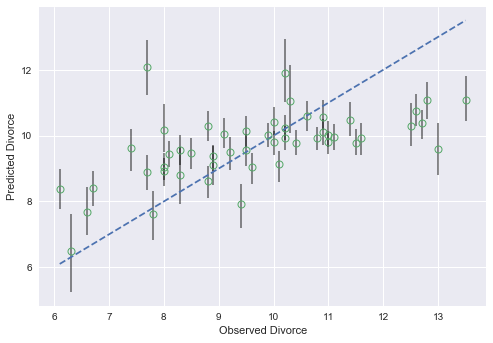

In [244]:
# Code 5.12
fig, ax = plt.subplots();
ax.set(xlabel='Observed Divorce', ylabel='Predicted Divorce');

# if predictions were perfect they'd lie on this line, i.e. observed = predicted divorce
observed_range = [d.Divorce.min(), d.Divorce.max()]
ax.plot(observed_range, observed_range, '--');

# actual observed vs predicted divorce
ax.plot(d.Divorce, mu_mean, 'o', fillstyle='none', mew=1);

# add confidence intervals around predictions
ax.vlines(x=d.Divorce, ymin=mu_PI[:, 0], ymax=mu_PI[:, 1], alpha=0.5);

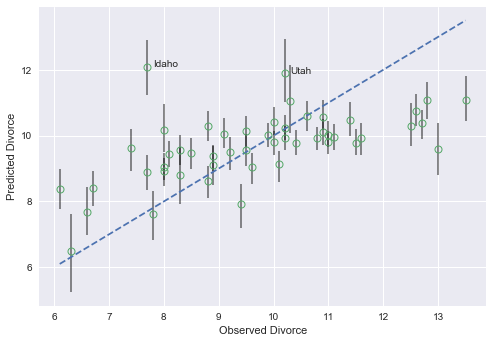

In [287]:
# Code 5.12
fig, ax = plt.subplots();
ax.set(xlabel='Observed Divorce', ylabel='Predicted Divorce');

# if predictions were perfect they'd lie on this line, i.e. observed = predicted divorce
observed_range = [d.Divorce.min(), d.Divorce.max()]
ax.plot(observed_range, observed_range, '--');

# actual observed vs predicted divorce
ax.plot(d.Divorce, mu_mean, 'o', fillstyle='none', mew=1);

# add confidence intervals around predictions
ax.vlines(x=d.Divorce, ymin=mu_PI[:, 0], ymax=mu_PI[:, 1], alpha=0.5);

# the same as above, but rolled into one command using 'errorbar' which plots
# data points and error bars

# ax.errorbar(
#     x=d.Divorce,
#     y=mu_mean,
#     yerr=np.abs(mu_PI - mu_mean.reshape(-1, 1)).reshape(2, -1),
#     fmt='o',
#     fillstyle='none',
#     mew=1
# );

# Code 5.13
# no neat 'identify' function, but this one also does the trick without needing to click anywwhere :)
annotate_pd = d[d.Location.isin(['Idaho', 'Utah'])]
annotate_ix = annotate_pd.index.values

for ix in annotate_ix:
    x = d.iloc[ix].Divorce + 0.1 # small offset to keep things legible
    y = mu_mean[ix]
    text = d.iloc[ix].Location

    ax.annotate(s=text, xy=(x, y));

* interpretation: model overpredicts for low divorce rate, underpredicts for high divorce rates
* some data points very far off, e.g. Utah and Idaho
* hard to see actual amount of error. create residual plot instead:

In [303]:
# Code 5.14

# compute residuals
divorce_resid = d.Divorce - mu_mean
# get ordering by divorce rate
o = divorce_resid.sort_values().index.values

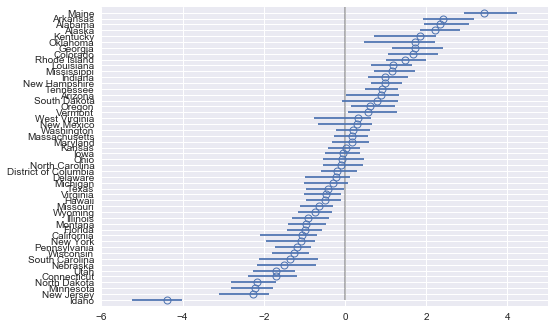

In [372]:
fig, ax = plt.subplots()

# x axis
ax.set_xlim(left=-6, right=5)

# y axis
ax.set_ylim(-1, o.size)
ax.set_yticks(range(0, o.size));
ax.set_yticklabels((d.iloc[o].Location.values));

# perfect prediction demarcation
ax.vlines(x=0, ymin=0, ymax=o.size, alpha=0.3);

# circles
# this seems to work
# ax.plot(divorce_resid.loc[o], range(0, o.size), 'o', fillstyle='none', mew=1);

# add confidence intervals around predictions
# this doesn't plot anything - why?
# eliminated causes: hlines not drawing anything, hlines not working with arrays
# ax.hlines(y=np.arange(0, o.size), xmin=mu_PI[o, 0], xmax=mu_PI[o, 1]);

# use errorbars instead
ax.errorbar(
    x=divorce_resid.loc[o],
    y=range(0, o.size),
    xerr=np.abs(mu_PI[o] - mu_mean[o].reshape(-1, 1)).reshape(2, -1),
    fmt='o',
    fillstyle='none',
    mew=1
);

* **observation: in contrast to book errors appear to not be symmetrical around mean. issue? reason? investigate!**
* **note: using order 'o' everywhere made it all very finicky. probably easier to make new dataframe which contains means and residuals, order that one and then plot from there**
* above plot makes it easier to see where model really goes wrong, e.g. Maine and Idaho
* might be infeasible to plot for large data sets
* another use for these estimates: create new predictor residual plots, i.e. new predictor vs residuals. shows if there's association between new predictor and outcome variable, even after controlling for other factors
* "does not mean that correlation is real. no matter how many predictors you've already included in regression, it's still possible to find spurious correlations with the remaining variation"
* **rethinking: stats, huh, yeah what is it good for?** statistics often asked questions it cannot answer, e.g. "is effect real or spurious?". but: modeling only quantifies uncertainty, conditional on the model ("in the way the model understands the problem"). Determining truth/causation in real world typically needs additional information not contained in model. E.g.: any correlation between predictor and dependent var can vanish or be reversed by including another new predictor. Might never find that one crucial predictor if we don't think about it. n:**model not guaranteed to be complete**. All models are vulnerable and need to be critiqued, however good they might look. Model criticism and revision are the **"real test"**, statistical tests are small bits of that process
* **overthinking: simulating spurious association**